# Wordle algorithm

### Loading libraries and game data

In [25]:
import csv
import math

import numpy as np
import matplotlib.pyplot as plt
import Wordle_functions as wrdl
import Wordle_algo as algo

from IPython.display import clear_output
from time import sleep
# from alive_progress import alive_it, config_handler
from scipy.special import expit #sigmoid function

# config_handler.set_global(force_tty=True, bar = "classic2", spinner = "classic", title='Playing Wordle intensively')

In [2]:
import importlib
importlib.reload(wrdl)
importlib.reload(algo)
dir(wrdl);

The official version of Wordle has a list of words that it will allow you to enter, that are considered valid guesses, that's just about 13,000 words long. We will call the list of words all_allowed. But when you look at it there's a lot of really uncommon things things like "aahed" or "aalii" and "aargh". The kind of words that bring about family arguments in a game of Scrabble. But the vibe of the game is that the answer is always going to be a decently common word, and in fact there's another list of around 2,300 words that are the possible answers. We will call this list solutions. This is a human-curated list, I think specifically by the game creator's girlfriend which is kind of fun.
But what I would like to do, our challenge for this project, is to see if we can write a program solving Wordle that doesn't incorporate previous knowledge about this list. For one thing there's plenty of pretty common five letter words that you won't find in that list, so it would be better to write a program that's a little more resilient and would play Wordle against anyone, not just what happens to be the official website. And also, the reason that we know what this list of possible answers is is because it's visible in the source code, but the way that it's visible in the source code is in the specific order in which answers come up from day to day, so you could always just look up what tomorrow's answer will be. So clearly there's some sense in which using the list is cheating, and what makes for a more interesting puzzle and a richer information theory lesson is to instead use some more universal data, like relative word frequencies in general, to capture this intuition of having a preference for more common words.

In [2]:
#Importing solutions and allowed words to lists
csv_reader = csv.reader(open('solutions.csv', 'r'))
solutions = list(csv_reader)[0] #contains all possible solutions

csv_reader = csv.reader(open('allowed_words.csv', 'r'))
allowed_words = list(csv_reader)[0] #contains allowed words beside solutions

all_allowed = allowed_words + solutions

In [26]:
len(all_allowed)
math.log2(len(all_allowed))


# inf = wrdl.standardize_freq_map(freq_map, reduced_list)
# inf = [p*math.log2(1/p) for (k, p) in inf.items()]
# inf = sum(inf)

13.663335723478353

In [29]:
7.08 + 3.49 + 3.49

14.06

In [30]:
7.22 + 3.00 + 1.79

12.009999999999998

### Wordle algorithms!!!

#### Algorithm number 1: Picking random words
It's literally just taking a random guess from all allowed words until it finds a solution
It completly ignores information given from game

In [4]:
#takes 2 minutes to run
taken_tries = algo.wordle_algorithm_1(solutions, all_allowed, bar=True)
invalid_guesses = [x for x in taken_tries if x > 6]
clear_output(wait=True)
sleep(2)
print(f"Average number of tries:\t{sum(taken_tries)/len(taken_tries):.2}")
print(f"Number of losses:\t\t{len(invalid_guesses)} = {len(invalid_guesses)/len(taken_tries):.2%}")

Playing Wordle intensively [########################################] 2309/2309 [100%] in 1:16.6 (30.16/s)              ................................] \ 34/2309 [1%] in 1s (28.0/s, eta: 1:28) [##......................................] - 117/2309 [5%] in 4s (26.7/s, eta: 1:23) 
Average number of tries:	6.5e+03
Number of losses:		2307 = 99.91%


#### Algorithm number 2: Filtering word list down

We're using the function "filter_words" here.
Given a guess, a reply and a list of possible solutions, it filters the possible solution
by throwing out all impossible solutions.

In [6]:
#Testing filter_words function
solution = "grade"
guess = "cigar"
answer = wrdl.wordle_reply(solution, guess)
print(answer)

reduced_list = wrdl.filter_words(guess, answer, all_allowed)
print(f"Original solution space: {len(all_allowed)}. Now: {len(reduced_list)}. Reduced list by {1-(len(reduced_list)/len(all_allowed)):.2%}")

[0, 0, 1, 1, 1]
Original solution space: 12974. Now: 78. Reduced list by 99.40%


In [7]:
#takes 15 seconds to run
taken_tries = algo.wordle_algorithm_2(solutions, all_allowed)
invalid_guesses = [x for x in taken_tries if x > 6]
clear_output(wait=True)
sleep(1)
print(f"Average number of tries:\t{sum(taken_tries)/len(taken_tries):.4}")
print(f"Number of losses:\t\t{len(invalid_guesses)} = {len(invalid_guesses)/len(taken_tries):.2%}")

Average number of tries:	4.902
Number of losses:		240 = 10.39%


#### Algorithm 3 Choosing word with highest expected information

Now we're calculating the expected entropy per word and choose the one with the greatest E[I]. For that we first need to generate a reply map with all possible replies we could get for a guess. Next we calculate the probability that a reply shows up for a given guess. From that
probability map we can calculate the expected entropy for a given guess. Let's test out the functions:

In [8]:
guess = "weary"
reply_map = wrdl.wordle_reply_generator()
gpm = wrdl.guess_probability_map(guess, all_allowed, {k: (1/len(all_allowed)) for k in all_allowed})
e = wrdl.expected_entropy_from_word(guess, all_allowed)
entropy_db = wrdl.load_entropy_db("entropy_db")
uniform_freq_map = {word: 1 for word in all_allowed}

print(f"guess: {guess}")
print(f"reply map: {reply_map[:4]}")
print(f"reply, prob: {gpm[:2]}")
print(f"E[I]: {e}")
print(f"Loaded hashes: {len(entropy_db)}")

guess: weary
reply map: [[0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 2], [0, 0, 0, 1, 0]]
reply, prob: [([0, 0, 0, 0, 0], 0.14213041467550358), ([0, 0, 0, 0, 1], 0.011484507476491428)]
E[I]: 4.902013055555535
Loaded hashes: 2779


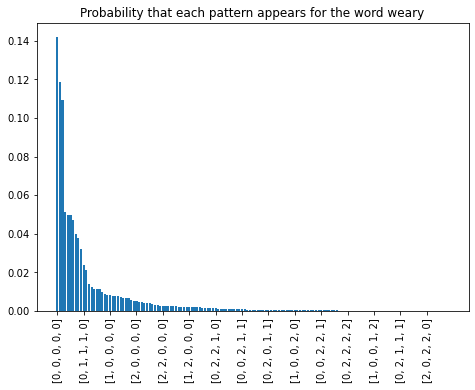

In [11]:
#plotting probability map for example word -> how likely each pattern is
guess = "weary"
gpm = wrdl.guess_probability_map(guess, all_allowed, {k: (1/len(all_allowed)) for k in all_allowed}) #uniform freq map must sum up to 1
gpm = sorted(gpm, key=lambda tup: tup[1], reverse = True) #sorts the list
x, y = zip(*gpm)
x = [str(i) for i in x]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
plt.xticks(np.arange(0, len(x)+1, 10), rotation=90)

plt.title(f"Probability that each pattern appears for the word {guess}")
plt.show()

In [12]:
#takes 6 minutes to run
taken_tries = algo.wordle_algorithm_4(solutions, all_allowed, verbose = False, entropy_db = entropy_db, freq_map = uniform_freq_map, bar = True)
invalid_guesses = [x for x in taken_tries if x > 6]
clear_output(wait=True)
sleep(1)
print(f"Average number of tries:\t{sum(taken_tries)/len(taken_tries):.4}")
print(f"Number of losses:\t\t{len(invalid_guesses)} = {len(invalid_guesses)/len(taken_tries):.2%}")

Average number of tries:	3.964
Number of losses:		0 = 0.00%


In [15]:
algo.wordle_algorithm_4(solutions, all_allowed, manual = True, entropy_db = entropy_db, freq_map = uniform_freq_map, bar = False)

🟩🟩🟩🟩🟩 yield E[I]:4.62 bits  I:0.00 bits  ✔️


[5]

### Algorithm 4: Taking word frequency into account

Currently, our best algorithm doesn't know which word is most likely to be the solution. When it is torn between 2 words, it doesn't take into account that 1 word is more common than the other. Let's change that.

In [17]:
#loading word frequency dataset and creating dictionary of word frequency for all allowed words
with open('unigram_freq.csv', 'r') as x:
    csv_reader = csv.reader(x)
    word_frequency_dict = list(csv_reader)

del word_frequency_dict[0] #delete headers
word_frequency_dict = [(i, int(j)) for i, j in word_frequency_dict]
total = sum(j for i, j in word_frequency_dict)
word_frequency_dict = dict((i, j/total) for i, j in word_frequency_dict)

all_allowed_freq = {}
mini = min(word_frequency_dict.values())

for word in all_allowed:
    if word in word_frequency_dict:
        all_allowed_freq[word] = word_frequency_dict[word]
    else: 
        all_allowed_freq[word] = mini

<BarContainer object of 20 artists>

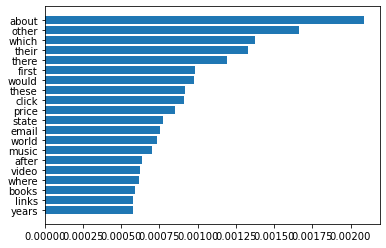

In [18]:
#plotting most common 5-letter-words
plot_data = sorted(all_allowed_freq.items(), key=lambda tup: tup[1])
plt.barh(*zip(*plot_data[-20:]))

In [19]:
all_allowed_freq_sigmoid = algo.apply_sigmoid(all_allowed_freq,10,-0.5)

tmp2 = {}
for s in solutions:
    tmp2[s] = all_allowed_freq_sigmoid[s]

print(f"Avg. probability solution \t{np.mean(list(tmp2.values())):.2%}")
print(f"Avg. probability all words \t{np.mean(list(all_allowed_freq_sigmoid.values())):.2%}")

Avg. probability solution 	80.55%
Avg. probability all words 	27.77%


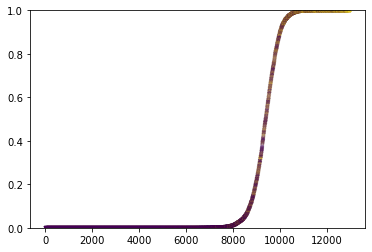

In [20]:
plot_data = list(all_allowed_freq_sigmoid.items())
plot_data.sort(key=lambda x:x[1]) #sort by frequency
y = list(zip(*plot_data))[1]
x = range(len(y))
c = list(zip(*plot_data))[0]
c = [1*(x in solutions) for x in c]
plt.ylim(0, 1)
plt.scatter(x, y, alpha = 0.1, c = c, s = 10, marker = "x")

In [21]:
guess = "sissy"
e = wrdl.expected_entropy_from_word(guess, all_allowed)
e_freq = wrdl.expected_entropy_from_word(guess, all_allowed, freq_map = all_allowed_freq_sigmoid)

print(f"guess:\t\t\t{guess}")
print(f"E[I] without freq:\t{e}")
print(f"E[I] with freq:\t\t{e_freq}")

guess:			sissy
E[I] without freq:	3.6985986851208272
E[I] with freq:		3.6007711675135794


In [22]:
#takes 7 minutes to run
taken_tries = algo.wordle_algorithm_4(solutions, all_allowed, verbose = False, entropy_db = entropy_db, freq_map = all_allowed_freq_sigmoid, bar = True)
invalid_guesses = [x for x in taken_tries if x > 6]

sleep(1)
clear_output(wait=True)
print(f"Average number of tries:\t{sum(taken_tries)/len(taken_tries):.4}")
print(f"Number of losses:\t\t{len(invalid_guesses)} = {len(invalid_guesses)/len(taken_tries):.2%}")

-> Currently solving fanny [########################################] 2309/2309 [100%] in 7:24.4 (5.20/s)               .................................] / 138/2309 [6%] in 27s (5.2/s, eta: 6:58) [###.....................................] - 171/2309 [7%] in 33s (5.3/s, eta: 6:49) [###.....................................] / 188/2309 [8%] in 36s (5.2/s, eta: 6:46) [#####...................................] - 261/2309 [11%] in 50s (5.2/s, eta: 6:35) [##########..............................] - 567/2309 [25%] in 1:50 (5.2/s, eta: 5:38) [###########.............................] / 650/2309 [28%] in 2:08 (5.1/s, eta: 5:26) [################........................] \ 914/2309 [40%] in 3:05 (4.9/s, eta: 4:42) [####################....................] | 1146/2309 [50%] in 3:53 (4.9/s, eta: 3:57) [#####################...................] \ 1189/2309 [51%] in 4:02 (4.9/s, eta: 3:48) [############################............] - 1627/2309 [70%] in 5:26 (5.0/s, eta: 2:17) [#####################